# Задание 2 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одна из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задаче в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [68]:
import json
import os
import csv
import urllib
import cv2
from io import BytesIO
from PIL import Image

from socket import timeout

#from google.colab import files

# !pip install torch 
# !pip install torchvision
# !pip install Pillow

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [69]:
# Download train data
#!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
#!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
#!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
#!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [70]:
train_folder

'train_kaggle/'

In [71]:
train_folder = "C:\\Users\\const31\\Documents\\OrNot\\train_kaggle"
test_folder = "C:\\Users\\const31\\Documents\\OrNot\\test_kaggle"

In [72]:
#example = '/home/malleo/ML/DL/Lection 5/HotDog or not/train_kaggle/chili-dog_7566.jpg'

In [73]:
import torch
import torchvision
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки.

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

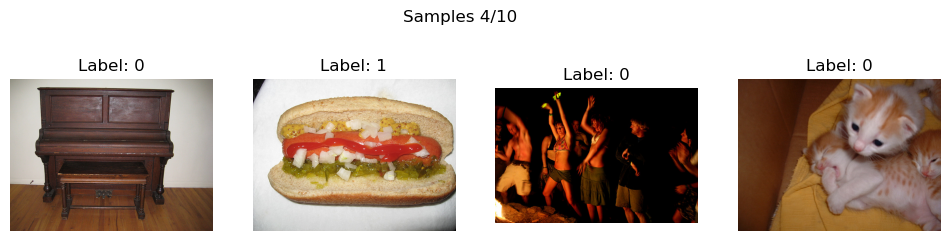

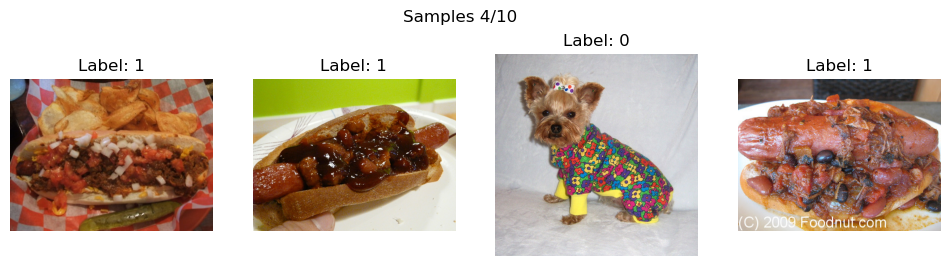

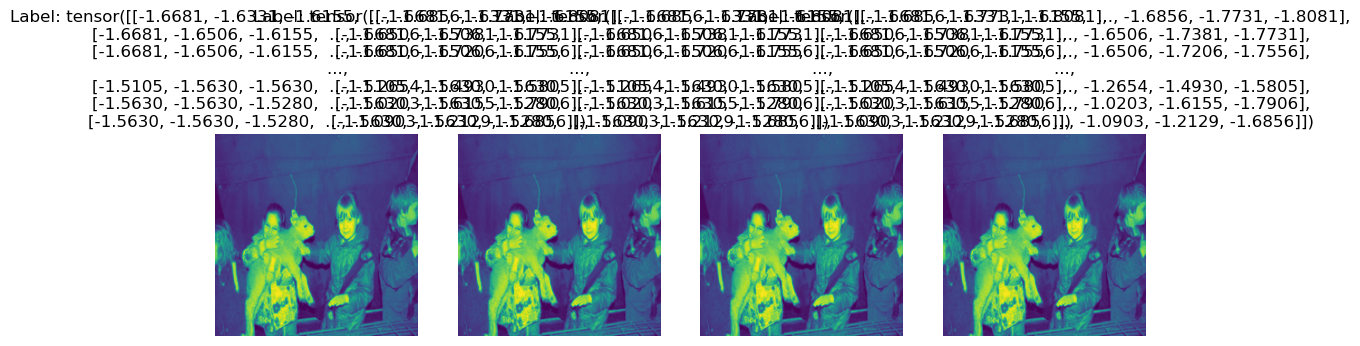

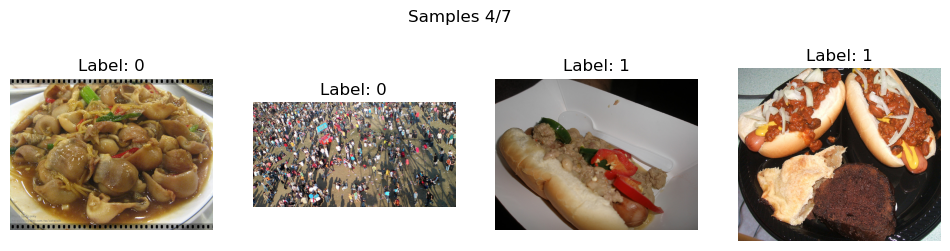

In [74]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        
        # TODO: Your code here!
        self.folder = folder
        self.list_folder = os.listdir(folder)
        
    def __len__(self):
        # TODO
        return len(self.list_folder)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        y = 1 if "frankfurter" in self.list_folder[index] or "chili-dog" in self.list_folder[index] or "hotdog" in self.list_folder[index] else 0

        img_path = os.path.join(self.folder, self.list_folder[index])
        img_id = self.list_folder[index]
        
        
        
        
        img = Image.open(img_path)

        #img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = img.astype(np.float32)
        #img = img/255.0

        #img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        #img = img.transpose((2, 0, 1))

        t_img = img
        #t_img = torch.from_numpy(img)
        #t_img = t_img.squeeze().permute(1,2,0)
        t_class_id = y
        #t_class_id = torch.tensor(y)
        
        
        if self.transform:
            #t_img = torch.from_numpy(img)
            t_img = self.transform(t_img) 
        
        return t_img, t_class_id, img_id

def visualize_samples(dataset, indices, title=None, count=4):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   


train_folder = "C:\\Users\\const31\\Documents\\OrNot\\train_kaggle"    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

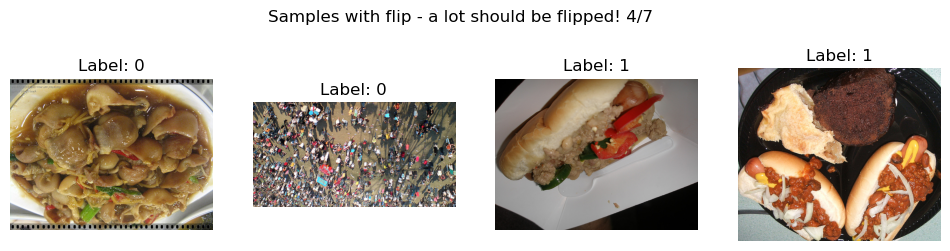

In [76]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(p=0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [77]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [78]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [79]:
len(train_dataset)

4603

In [80]:
for sample in train_loader:
    print(sample)

[tensor([[[[-1.4672, -1.4672, -1.4500,  ..., -1.7412, -1.6384, -1.5357],
          [-1.4329, -1.3644, -1.3987,  ..., -1.6898, -1.6213, -1.5870],
          [-1.4672, -1.3987, -1.4672,  ..., -1.7069, -1.6727, -1.7069],
          ...,
          [-1.1075, -1.1247, -1.1075,  ...,  0.0398,  0.0912,  0.0056],
          [-1.1418, -1.1589, -1.0904,  ...,  0.0227,  0.0227, -0.0116],
          [-1.0733, -1.1247, -1.0562,  ...,  0.0227, -0.0458, -0.1143]],

         [[-0.7052, -0.6877, -0.6877,  ..., -1.3004, -1.1779, -1.0553],
          [-0.6702, -0.6176, -0.6527,  ..., -1.2304, -1.1779, -1.1253],
          [-0.7052, -0.6527, -0.6877,  ..., -1.2129, -1.1779, -1.2129],
          ...,
          [-1.8256, -1.8431, -1.8256,  ..., -0.1975, -0.1275, -0.2150],
          [-1.8081, -1.8256, -1.8256,  ..., -0.2150, -0.2150, -0.2500],
          [-1.7731, -1.8081, -1.7906,  ..., -0.2150, -0.2675, -0.3550]],

         [[-0.8807, -0.8633, -0.8633,  ..., -1.6999, -1.6650, -1.6127],
          [-0.8458, -0.7761, 

[tensor([[[[-0.4739, -0.4739, -0.4739,  ..., -1.0219, -1.0219, -0.9363],
          [-0.4226, -0.4568, -0.4739,  ..., -0.9705, -1.0219, -0.9020],
          [-0.3883, -0.4226, -0.4568,  ..., -0.9877, -1.0562, -0.9534],
          ...,
          [ 0.1426,  0.0912, -0.0629,  ..., -2.1179, -2.1008, -1.5185],
          [-0.1999, -0.2856, -0.0629,  ..., -2.0837, -2.0837, -1.5357],
          [-0.1143,  0.2624,  0.3138,  ..., -1.1075, -1.1247, -0.7650]],

         [[-1.8431, -1.8431, -1.8256,  ..., -2.0007, -2.0007, -1.4055],
          [-1.8256, -1.8606, -1.8431,  ..., -2.0182, -2.0007, -1.4230],
          [-1.7906, -1.8431, -1.8606,  ..., -2.0182, -2.0007, -1.4230],
          ...,
          [-1.1078, -1.1604, -1.4230,  ..., -2.0357, -2.0182, -1.4230],
          [-1.5105, -1.5805, -1.5280,  ..., -2.0007, -2.0007, -1.4405],
          [-0.9503, -0.8803, -0.7752,  ..., -1.0028, -1.0203, -0.6527]],

         [[-1.2816, -1.3513, -1.3339,  ..., -1.7870, -1.7696, -1.1944],
          [-1.2816, -1.3687, 

[tensor([[[[ 0.1597,  0.1597,  0.1597,  ..., -0.4568, -0.4568, -0.4739],
          [ 0.1768,  0.1768,  0.1768,  ..., -0.4568, -0.4568, -0.4739],
          [ 0.2453,  0.2453,  0.2453,  ..., -0.4568, -0.4568, -0.4739],
          ...,
          [-1.2274, -1.2274, -1.2617,  ..., -0.1486, -0.2856,  0.3481],
          [-1.2274, -1.2274, -1.2617,  ..., -0.1143, -0.2171,  0.3652],
          [-1.2274, -1.2274, -1.2617,  ...,  0.2967,  0.2111,  0.7248]],

         [[ 0.5728,  0.5728,  0.5728,  ..., -0.4951, -0.4951, -0.5126],
          [ 0.5903,  0.5903,  0.5903,  ..., -0.4951, -0.4951, -0.5126],
          [ 0.6604,  0.6604,  0.6604,  ..., -0.4951, -0.4951, -0.5126],
          ...,
          [-0.8627, -0.8627, -0.8978,  ..., -0.0224, -0.1625,  0.4853],
          [-0.8627, -0.8627, -0.8978,  ...,  0.0126, -0.0924,  0.5028],
          [-0.8627, -0.8627, -0.8978,  ...,  0.4328,  0.3452,  0.8704]],

         [[ 1.0191,  1.0191,  1.0191,  ..., -0.2184, -0.2184, -0.2358],
          [ 1.0365,  1.0365, 

[tensor([[[[-1.8610, -1.8610, -1.8953,  ..., -0.3027, -0.2684, -0.2684],
          [-1.8439, -1.8610, -1.8610,  ..., -0.3369, -0.3027, -0.3198],
          [-1.8268, -1.8610, -1.8610,  ..., -0.3883, -0.3883, -0.3712],
          ...,
          [-1.5014, -1.1760, -0.8335,  ...,  0.8961,  0.8789,  0.8618],
          [-1.4500, -1.0219, -0.7479,  ...,  0.8961,  0.8961,  0.8789],
          [-1.3987, -0.8849, -0.7308,  ...,  0.8789,  0.8789,  0.8447]],

         [[-1.9307, -1.9307, -1.9307,  ..., -0.8452, -0.8102, -0.7927],
          [-1.8957, -1.9132, -1.8957,  ..., -0.8803, -0.8452, -0.8102],
          [-1.8957, -1.8957, -1.8957,  ..., -0.9328, -0.8978, -0.8452],
          ...,
          [-1.7731, -1.6856, -1.4930,  ...,  0.3978,  0.3803,  0.3627],
          [-1.7731, -1.5630, -1.4230,  ...,  0.4153,  0.3978,  0.3803],
          [-1.7381, -1.4930, -1.4230,  ...,  0.3978,  0.3803,  0.3452]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.2990, -1.2641, -1.2990],
          [-1.8044, -1.8044, 

[tensor([[[[ 1.7009,  1.7352,  1.7180,  ...,  1.3070,  1.3070,  1.3070],
          [ 1.6838,  1.7180,  1.7180,  ...,  1.3242,  1.2899,  1.3070],
          [ 1.6838,  1.7009,  1.7352,  ...,  1.3242,  1.3242,  1.2899],
          ...,
          [ 0.6906,  0.5364, -0.9363,  ..., -1.7925, -1.7583, -1.7240],
          [ 0.7419,  0.6392, -0.2171,  ..., -1.7925, -1.8268, -1.7925],
          [ 0.8276,  0.7591,  0.3309,  ..., -1.8097, -1.8268, -1.7754]],

         [[ 1.5882,  1.6057,  1.5882,  ...,  1.4482,  1.4307,  1.4307],
          [ 1.5707,  1.5882,  1.5707,  ...,  1.4482,  1.4307,  1.4482],
          [ 1.5707,  1.5532,  1.5707,  ...,  1.4482,  1.4307,  1.4307],
          ...,
          [ 0.8179,  0.6954, -0.7927,  ..., -1.5805, -1.5980, -1.5630],
          [ 0.8704,  0.7829, -0.0749,  ..., -1.5805, -1.6506, -1.5805],
          [ 0.9230,  0.8529,  0.5028,  ..., -1.6155, -1.6155, -1.5805]],

         [[ 1.5245,  1.5071,  1.4548,  ...,  1.3154,  1.2980,  1.2282],
          [ 1.4897,  1.4897, 

[tensor([[[[-1.6898, -1.6898, -1.6727,  ..., -0.4054, -0.4054, -0.3712],
          [-1.8439, -1.8268, -1.8097,  ..., -0.4568, -0.4397, -0.3883],
          [-1.9124, -1.9124, -1.8953,  ..., -0.5253, -0.4911, -0.4568],
          ...,
          [-0.0972, -0.0458,  0.0912,  ...,  1.3755,  1.3755,  1.3927],
          [-0.0287,  0.0227,  0.0569,  ...,  1.3584,  1.3927,  1.4098],
          [ 0.0741,  0.1426,  0.1597,  ...,  1.3755,  1.4269,  1.4440]],

         [[-1.7556, -1.7556, -1.7381,  ..., -0.7227, -0.7227, -0.6877],
          [-1.8606, -1.8431, -1.8081,  ..., -0.7402, -0.7227, -0.6702],
          [-1.8606, -1.8606, -1.8606,  ..., -0.7752, -0.7402, -0.7227],
          ...,
          [-0.2500, -0.2150, -0.0924,  ...,  1.1506,  1.1331,  1.1331],
          [-0.1625, -0.1625, -0.1450,  ...,  1.1331,  1.1681,  1.2031],
          [-0.0574, -0.0574, -0.0399,  ...,  1.1506,  1.2206,  1.2381]],

         [[-1.5081, -1.5081, -1.5081,  ..., -0.4624, -0.4450, -0.3753],
          [-1.6476, -1.6476, 

[tensor([[[[-1.2445, -1.2103, -1.1418,  ..., -1.2445, -1.2445, -1.3130],
          [-1.2103, -1.2274, -1.2445,  ..., -1.2445, -1.2617, -1.3130],
          [-1.2445, -1.2274, -1.2617,  ..., -1.2445, -1.2445, -1.2788],
          ...,
          [-1.5014, -1.7925, -1.9980,  ..., -1.5870, -1.5357, -1.5528],
          [-1.4329, -1.7240, -1.9638,  ..., -1.6213, -1.5699, -1.5185],
          [-1.3644, -1.6384, -1.9124,  ..., -1.6042, -1.6042, -1.4843]],

         [[-1.9307, -1.9132, -1.8606,  ..., -1.9307, -1.9307, -1.9657],
          [-1.9132, -1.9307, -1.9657,  ..., -1.9307, -1.9657, -2.0007],
          [-1.9132, -1.9132, -1.9657,  ..., -1.9307, -1.9482, -1.9657],
          ...,
          [-1.3880, -1.6681, -1.8256,  ..., -1.1954, -1.2129, -1.2129],
          [-1.3179, -1.6155, -1.8081,  ..., -1.1779, -1.1779, -1.1078],
          [-1.2479, -1.5105, -1.7556,  ..., -1.1429, -1.1779, -1.0378]],

         [[-1.5779, -1.5256, -1.4559,  ..., -1.5779, -1.5604, -1.5779],
          [-1.5430, -1.5430, 

[tensor([[[[-1.5870, -1.6898, -1.7583,  ..., -1.6042, -1.6555, -1.6213],
          [-1.5870, -1.6042, -1.6384,  ..., -1.7069, -1.6898, -1.6384],
          [-1.5185, -1.5699, -1.5185,  ..., -1.6213, -1.6555, -1.6727],
          ...,
          [-1.6555, -1.6042, -1.6213,  ..., -1.0733, -1.0562, -1.1760],
          [-1.6213, -1.5870, -1.5870,  ..., -1.0733, -1.0733, -1.0733],
          [-1.5528, -1.5699, -1.6384,  ..., -1.0904, -1.1247, -0.9705]],

         [[-1.3704, -1.4755, -1.4930,  ..., -1.3179, -1.3529, -1.3704],
          [-1.3179, -1.4055, -1.4405,  ..., -1.3004, -1.3354, -1.3529],
          [-1.2479, -1.3529, -1.3529,  ..., -1.3354, -1.3004, -1.3004],
          ...,
          [-1.3354, -1.3179, -1.4055,  ..., -1.3529, -1.2829, -1.3704],
          [-1.3704, -1.3354, -1.4405,  ..., -1.3004, -1.2479, -1.3004],
          [-1.4230, -1.4230, -1.4755,  ..., -1.4230, -1.3179, -1.2829]],

         [[-1.1247, -1.2119, -1.2293,  ..., -0.9504, -1.0027, -1.0201],
          [-1.1073, -1.1770, 

[tensor([[[[ 0.8276,  0.9132,  1.5125,  ...,  0.8961,  0.2111,  1.0331],
          [ 1.1015,  1.3755,  1.5297,  ...,  0.4851,  0.5536,  0.7762],
          [ 1.4098,  1.2557,  1.4269,  ...,  0.3652,  0.6906,  0.8447],
          ...,
          [ 1.0673,  0.9988,  1.2899,  ...,  1.8379,  1.5810,  1.4440],
          [ 1.3413,  1.1015,  1.1529,  ...,  1.7009,  1.6838,  1.4612],
          [ 1.7694,  1.5639,  1.3070,  ...,  1.3242,  1.1872,  1.2728]],

         [[ 0.7304,  0.7479,  1.5182,  ...,  1.2206,  0.4503,  1.7458],
          [ 1.0980,  1.5532,  1.7458,  ...,  0.9230,  1.0630,  1.6933],
          [ 1.5357,  1.4132,  1.6933,  ...,  0.6604,  1.4832,  1.7283],
          ...,
          [ 1.1681,  1.0805,  1.3782,  ...,  1.9909,  1.7108,  1.6057],
          [ 1.5882,  1.2731,  1.2206,  ...,  1.8158,  1.7633,  1.6057],
          [ 1.9034,  1.7283,  1.4832,  ...,  1.4482,  1.2381,  1.3606]],

         [[-0.1835,  0.2871,  1.4025,  ...,  1.6291,  0.7925,  2.4831],
          [ 0.7054,  1.6291, 

[tensor([[[[-1.5014, -1.4843, -1.4500,  ...,  1.2043,  1.0331,  0.7419],
          [-1.4500, -1.4672, -1.4329,  ...,  0.7591,  0.5536,  0.7933],
          [-1.0733, -1.0904, -1.1075,  ...,  0.2796,  0.3652,  0.3138],
          ...,
          [-2.0837, -2.0665, -2.0665,  ..., -1.1760, -1.2103, -1.2274],
          [-2.0837, -2.0837, -2.1008,  ..., -1.1247, -1.1589, -1.1418],
          [-2.0837, -2.1008, -2.1008,  ..., -1.1418, -1.1760, -1.1075]],

         [[-1.3704, -1.3529, -1.2654,  ...,  1.3957,  1.2556,  0.9580],
          [-1.3004, -1.3529, -1.3179,  ...,  1.1506,  0.9230,  1.1506],
          [-0.9503, -0.9678, -1.0028,  ...,  0.5553,  0.5378,  0.5203],
          ...,
          [-2.0007, -1.9832, -1.9832,  ..., -1.4580, -1.5105, -1.5455],
          [-2.0007, -2.0007, -2.0182,  ..., -1.4580, -1.4580, -1.5105],
          [-2.0007, -2.0182, -2.0182,  ..., -1.4755, -1.4230, -1.4405]],

         [[-0.9853, -0.9853, -0.9330,  ...,  1.6640,  1.5245,  1.2108],
          [-0.9853, -0.9853, 

[tensor([[[[-0.3027,  0.0227,  0.3994,  ..., -1.2788, -1.1932, -1.2445],
          [-0.3883, -0.0801,  0.1939,  ..., -1.1589, -1.1075, -1.1418],
          [-0.6623, -0.3198, -0.0972,  ..., -0.9020, -0.5596, -0.4226],
          ...,
          [ 1.3927,  1.4269,  1.4098,  ...,  1.0331,  1.0159,  1.0502],
          [ 1.3413,  1.3584,  1.3242,  ...,  1.1358,  1.0673,  1.1015],
          [ 1.2557,  1.2899,  1.2728,  ...,  1.1358,  1.1872,  1.2214]],

         [[-0.5826, -0.3725, -0.0924,  ..., -1.8081, -1.7031, -1.7731],
          [-0.7227, -0.5476, -0.3725,  ..., -1.7381, -1.7906, -1.8256],
          [-0.7402, -0.6001, -0.5826,  ..., -1.4930, -1.2829, -1.1253],
          ...,
          [ 1.3957,  1.4307,  1.4132,  ...,  0.8880,  0.9055,  0.9055],
          [ 1.3431,  1.3606,  1.3256,  ...,  0.9755,  0.9580,  0.9930],
          [ 1.2556,  1.2731,  1.2556,  ...,  1.0105,  1.0805,  1.1506]],

         [[-1.4210, -1.3861, -1.0201,  ..., -1.6302, -1.5256, -1.5779],
          [-1.3687, -1.3687, 

[tensor([[[[ 0.4508,  0.4851,  0.5022,  ..., -0.0458, -0.0287,  0.0056],
          [ 0.4851,  0.4508,  0.4508,  ...,  0.0056, -0.0116,  0.0056],
          [ 0.4508,  0.4166,  0.4166,  ...,  0.0398,  0.0056,  0.0227],
          ...,
          [-0.2342, -0.2856, -0.2684,  ...,  1.4269,  1.1872,  0.7248],
          [-0.1486, -0.1657, -0.1657,  ...,  1.3584,  0.9817,  0.5022],
          [-0.0801, -0.0287, -0.1143,  ...,  1.2557,  0.7933,  0.2282]],

         [[-0.2150, -0.2325, -0.1975,  ..., -0.5826, -0.5651, -0.5651],
          [-0.2150, -0.2150, -0.1800,  ..., -0.5826, -0.5826, -0.5651],
          [-0.2150, -0.2325, -0.2150,  ..., -0.5651, -0.5651, -0.5476],
          ...,
          [-0.9153, -0.9503, -0.9328,  ...,  1.7283,  1.3782,  0.8880],
          [-0.8627, -0.8627, -0.8452,  ...,  1.6057,  1.1681,  0.5903],
          [-0.8102, -0.7927, -0.8452,  ...,  1.4657,  0.9405,  0.2402]],

         [[-0.3753, -0.3927, -0.3578,  ..., -0.8110, -0.7587, -0.7587],
          [-0.3578, -0.3753, 

[tensor([[[[ 1.3413,  1.2214,  1.7009,  ...,  0.6221,  1.2557,  1.9407],
          [ 0.6049,  0.6563,  1.0159,  ...,  0.4337,  0.8961,  1.4783],
          [ 0.0569,  0.5193,  0.3481,  ..., -0.1657,  0.6563,  0.9132],
          ...,
          [ 1.2557,  1.2043,  1.1700,  ...,  1.9064,  1.6667,  1.3927],
          [ 1.2043,  1.2385,  1.3242,  ...,  1.9920,  1.7523,  1.4954],
          [ 1.1358,  1.2043,  1.3927,  ...,  1.8893,  1.6838,  1.5125]],

         [[ 0.3978,  0.2752,  0.7654,  ..., -0.0924,  0.4678,  1.1155],
          [-0.3550, -0.3025,  0.0476,  ..., -0.2850,  0.1176,  0.6429],
          [-0.9153, -0.4251, -0.6001,  ..., -0.8978, -0.1450,  0.0651],
          ...,
          [ 0.3452,  0.2927,  0.2577,  ...,  1.0630,  0.8004,  0.5203],
          [ 0.2927,  0.3277,  0.4153,  ...,  1.1506,  0.9055,  0.6254],
          [ 0.2402,  0.3102,  0.5028,  ...,  1.0455,  0.8179,  0.6429]],

         [[-0.0615, -0.2010,  0.2522,  ..., -0.5321, -0.0615,  0.5485],
          [-0.8633, -0.8284, 

[tensor([[[[ 1.3413,  1.3413,  1.4098,  ..., -1.9124, -1.8953, -1.9467],
          [ 1.3584,  1.3755,  1.4098,  ..., -1.9124, -1.8439, -1.8953],
          [ 1.3242,  1.3755,  1.3927,  ..., -1.9124, -1.8439, -1.8782],
          ...,
          [ 1.2385,  1.2899,  1.3070,  ...,  0.8961,  0.9303,  0.9303],
          [ 1.1700,  1.2557,  1.2728,  ...,  0.8789,  0.8961,  0.8789],
          [ 0.9817,  1.0673,  1.1700,  ...,  0.8104,  0.8447,  0.8618]],

         [[ 1.2731,  1.2731,  1.3431,  ..., -2.0007, -1.9482, -1.9832],
          [ 1.2906,  1.3081,  1.3431,  ..., -1.9657, -1.8957, -1.9482],
          [ 1.2731,  1.3081,  1.3256,  ..., -1.9832, -1.8957, -1.9307],
          ...,
          [ 0.9930,  1.0105,  1.0280,  ...,  0.3452,  0.3803,  0.3803],
          [ 0.8880,  0.9580,  0.9930,  ...,  0.2927,  0.3102,  0.3277],
          [ 0.6604,  0.7479,  0.8704,  ...,  0.2227,  0.2577,  0.2927]],

         [[ 1.3502,  1.3502,  1.4200,  ..., -1.6824, -1.6999, -1.7347],
          [ 1.3154,  1.3677, 

[tensor([[[[-1.8268, -1.7240, -1.5014,  ..., -1.3644, -1.4500, -1.5014],
          [-1.7925, -1.7583, -1.6727,  ..., -1.4329, -1.4329, -1.4500],
          [-1.6727, -1.7069, -1.7412,  ..., -1.4329, -1.4500, -1.4672],
          ...,
          [-1.5870, -1.5528, -1.5528,  ..., -1.6213, -1.5699, -1.7412],
          [-1.5528, -1.4672, -1.5699,  ..., -1.5014, -1.6042, -1.7412],
          [-1.5014, -1.4500, -1.4329,  ..., -1.5357, -1.5870, -1.6384]],

         [[-1.7381, -1.5805, -1.3179,  ..., -1.1429, -1.2129, -1.3004],
          [-1.6856, -1.6856, -1.5280,  ..., -1.2654, -1.2479, -1.2479],
          [-1.5455, -1.5805, -1.6506,  ..., -1.2829, -1.2654, -1.2829],
          ...,
          [-1.3880, -1.3704, -1.3529,  ..., -1.3880, -1.3529, -1.5455],
          [-1.3704, -1.2829, -1.3529,  ..., -1.2654, -1.3880, -1.5455],
          [-1.3179, -1.2479, -1.2129,  ..., -1.3179, -1.3880, -1.4405]],

         [[-1.6127, -1.5604, -1.3687,  ..., -1.1944, -1.2119, -1.2467],
          [-1.5953, -1.5953, 

[tensor([[[[-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          ...,
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9467, -1.9467, -1.9467,  ..., -1.9467, -1.9467, -1.9467]],

         [[-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          ...,
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431]],

         [[-1.5430, -1.5430, -1.5430,  ..., -1.5430, -1.5430, -1.5430],
          [-1.5430, -1.5430, 

[tensor([[[[-1.3130, -1.3987, -1.5185,  ...,  0.0741,  0.1083,  0.1083],
          [-1.3302, -1.4329, -1.5528,  ...,  0.1426,  0.1768,  0.1768],
          [-1.3473, -1.4500, -1.6042,  ...,  0.1939,  0.2282,  0.2111],
          ...,
          [-2.1008, -2.1008, -2.0837,  ...,  1.0673,  1.0331,  0.3994],
          [-2.0837, -2.1008, -2.1179,  ...,  1.3242,  0.9303,  0.2111],
          [-2.0837, -2.1179, -2.1179,  ...,  0.1597,  0.0912,  0.0741]],

         [[ 1.2206,  1.1155,  0.9755,  ...,  0.1176,  0.1527,  0.1527],
          [ 1.2206,  1.0980,  0.9405,  ...,  0.1877,  0.2227,  0.2227],
          [ 1.2206,  1.0980,  0.8880,  ...,  0.2402,  0.2752,  0.2577],
          ...,
          [-1.4055, -1.4055, -1.3880,  ...,  0.9580,  0.9405,  0.2927],
          [-1.3880, -1.4055, -1.4230,  ...,  1.2206,  0.8179,  0.0826],
          [-1.3880, -1.4230, -1.4230,  ...,  0.0126, -0.0574, -0.0749]],

         [[ 1.3154,  1.2108,  1.0714,  ...,  0.4439,  0.4788,  0.4788],
          [ 1.3154,  1.1934, 

[tensor([[[[ 1.4612,  1.4440,  1.4269,  ..., -0.6965, -0.7137, -0.7822],
          [ 1.5125,  1.4440,  1.4269,  ..., -0.6794, -0.6794, -0.7137],
          [ 1.4954,  1.4783,  1.4783,  ..., -0.7308, -0.7650, -0.7650],
          ...,
          [ 0.3652,  0.3994,  0.3823,  ..., -0.0458, -0.0972, -0.0458],
          [ 0.4166,  0.3994,  0.3309,  ..., -0.0287, -0.0287, -0.0287],
          [ 0.3481,  0.3994,  0.3994,  ..., -0.0458,  0.0056, -0.0287]],

         [[ 1.2206,  1.2206,  1.2206,  ..., -0.7402, -0.7227, -0.7402],
          [ 1.2381,  1.2556,  1.2556,  ..., -0.7402, -0.7752, -0.8102],
          [ 1.2381,  1.2731,  1.2906,  ..., -0.7402, -0.7577, -0.7577],
          ...,
          [-0.0574, -0.0049, -0.0049,  ..., -0.2325, -0.2150, -0.2150],
          [-0.0049, -0.0224, -0.0224,  ..., -0.2325, -0.2325, -0.2325],
          [-0.0749, -0.0399, -0.0049,  ..., -0.2150, -0.2325, -0.2325]],

         [[-0.4101, -0.4450, -0.4624,  ..., -0.6367, -0.7413, -0.7587],
          [-0.4101, -0.4624, 

[tensor([[[[ 2.0092,  2.0092,  1.9749,  ...,  1.0331,  0.9988,  0.9474],
          [ 2.0263,  2.0092,  1.9920,  ...,  1.0502,  1.0159,  0.9988],
          [ 2.0263,  2.0434,  2.0263,  ...,  1.0673,  1.0673,  1.0673],
          ...,
          [ 2.2489,  2.1975,  2.1975,  ...,  0.0056,  0.0569,  0.0741],
          [ 2.2318,  2.2147,  2.2318,  ...,  0.0741,  0.0741,  0.0741],
          [ 2.2489,  2.2318,  2.2489,  ...,  0.0569,  0.0569,  0.0741]],

         [[ 0.9055,  0.9055,  0.8880,  ...,  0.0651,  0.0476,  0.0301],
          [ 0.9230,  0.9055,  0.9055,  ...,  0.1001,  0.0826,  0.0651],
          [ 0.9055,  0.9230,  0.9230,  ...,  0.1702,  0.1527,  0.1352],
          ...,
          [ 1.9034,  1.7983,  1.6758,  ..., -0.3375, -0.3025, -0.2850],
          [ 1.7633,  1.7283,  1.7633,  ..., -0.2675, -0.2675, -0.2500],
          [ 1.7108,  1.7458,  1.8333,  ..., -0.2500, -0.2500, -0.2325]],

         [[-0.6715, -0.6541, -0.6018,  ..., -0.9678, -0.9853, -1.0201],
          [-0.6367, -0.6193, 

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.2513, -0.2171, -0.1828,  ..., -0.8507, -0.7822, -0.8335],
          [-0.2684, -0.2171, -0.1828,  ..., -0.7650, -0.7650, -0.8849],
          [-0.3027, -0.2513, -0.1999,  ..., -0.7650, -0.7822, -0.9020]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0182, -2.0357, -2.0357,  ..., -1.4230, -1.4755, -1.4755],
          [-2.0357, -2.0357, -2.0357,  ..., -1.3354, -1.4755, -1.5105],
          [-2.0357, -2.0357, -2.0357,  ..., -1.3004, -1.4930, -1.5280]],

         [[-1.7347, -1.7870, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.7347, -1.7696, 

[tensor([[[[-1.6042, -1.6213, -1.6384,  ...,  0.0227,  0.1254,  0.2111],
          [-1.7754, -1.7754, -1.6898,  ...,  0.1254,  0.0569,  0.0398],
          [-1.8782, -1.9124, -1.8268,  ...,  0.1597, -0.1486, -0.1657],
          ...,
          [-2.1008, -2.1008, -2.0837,  ..., -0.0972, -0.0287, -0.2513],
          [-2.0837, -2.1008, -2.1008,  ..., -0.1143, -0.1828, -0.0629],
          [-2.0837, -2.1008, -2.0837,  ..., -0.2856, -0.0972, -0.0629]],

         [[-1.2304, -1.2479, -1.3004,  ...,  0.5028,  0.6604,  0.7304],
          [-1.4405, -1.4230, -1.4405,  ...,  0.6604,  0.6429,  0.6429],
          [-1.6331, -1.6506, -1.6681,  ...,  0.5728,  0.3978,  0.3978],
          ...,
          [-1.8081, -1.7906, -1.8081,  ...,  0.3452,  0.4153,  0.2577],
          [-1.7906, -1.8081, -1.8081,  ...,  0.3452,  0.2402,  0.3627],
          [-1.8081, -1.8256, -1.8081,  ...,  0.1527,  0.3277,  0.3803]],

         [[-0.7761, -0.7413, -0.8458,  ...,  0.0082,  0.1825,  0.2348],
          [-1.0376, -1.0201, 

[tensor([[[[ 0.8276,  0.7591,  0.7933,  ...,  0.3309,  0.1597, -0.0629],
          [ 0.7762,  0.7591,  0.7248,  ...,  0.3481,  0.5022,  0.4337],
          [ 0.8618,  0.8447,  0.7591,  ...,  0.3309,  0.5364,  0.7419],
          ...,
          [-0.7993, -0.7822, -0.7479,  ...,  2.1119,  2.1119,  2.1119],
          [-0.8164, -0.7993, -0.7479,  ...,  2.0263,  2.0434,  2.0263],
          [-0.8335, -0.8335, -0.8164,  ...,  2.0605,  2.1119,  2.1119]],

         [[-1.4230, -1.5980, -1.6681,  ...,  0.4503,  0.2927,  0.0826],
          [-1.3529, -1.5105, -1.6506,  ...,  0.5553,  0.6254,  0.5028],
          [-1.2479, -1.4930, -1.6331,  ...,  0.5378,  0.7829,  0.9230],
          ...,
          [ 0.4853,  0.4853,  0.5203,  ...,  2.4111,  2.4111,  2.4111],
          [ 0.4678,  0.4853,  0.5378,  ...,  2.4286,  2.4111,  2.4111],
          [ 0.4503,  0.4678,  0.5028,  ...,  2.4286,  2.4111,  2.4111]],

         [[-1.0724, -1.2641, -1.3687,  ...,  0.1302, -0.2532, -0.4275],
          [-1.0376, -1.2293, 

[tensor([[[[-1.6727, -1.7240, -1.6898,  ..., -1.8953, -1.8782, -1.8953],
          [-1.7240, -1.7240, -1.6727,  ..., -1.6384, -1.6384, -1.6384],
          [-1.6727, -1.6898, -1.6727,  ..., -1.3302, -1.3644, -1.3815],
          ...,
          [-0.8678, -0.8164, -0.8335,  ..., -1.4158, -1.3987, -1.3473],
          [-1.0048, -0.9534, -0.9534,  ..., -1.3644, -1.3987, -1.3302],
          [-0.8507, -0.8164, -0.8507,  ..., -1.4158, -1.3987, -1.3987]],

         [[-1.3004, -1.2654, -1.3179,  ..., -1.5455, -1.5630, -1.5630],
          [-1.2304, -1.2304, -1.2829,  ..., -1.2654, -1.3354, -1.3354],
          [-1.1429, -1.1954, -1.2129,  ..., -0.7752, -0.7752, -0.7927],
          ...,
          [-0.3901, -0.3375, -0.2675,  ..., -0.8452, -0.8277, -0.8277],
          [-0.4951, -0.4951, -0.4601,  ..., -0.8452, -0.7927, -0.7927],
          [-0.2675, -0.2500, -0.3200,  ..., -0.8978, -0.8803, -0.8627]],

         [[-0.4101, -0.5670, -0.5321,  ..., -0.8981, -0.8981, -0.9678],
          [-0.4275, -0.4624, 

[tensor([[[[-1.3130, -1.2617, -1.1760,  ..., -0.9534, -0.9877, -1.0048],
          [-1.2959, -1.2445, -1.1760,  ..., -0.9534, -1.0219, -1.0390],
          [-1.2959, -1.2274, -1.2103,  ..., -0.9534, -1.0219, -0.9877],
          ...,
          [-1.7925, -1.8097, -1.8097,  ..., -1.3130, -1.3473, -1.2788],
          [-1.7754, -1.8097, -1.8097,  ..., -1.3130, -1.3302, -1.2788],
          [-1.7754, -1.8268, -1.8439,  ..., -1.2959, -1.2959, -1.1932]],

         [[-1.8431, -1.8431, -1.8431,  ..., -1.5105, -1.5455, -1.5805],
          [-1.8782, -1.8782, -1.8606,  ..., -1.5105, -1.5455, -1.5805],
          [-1.8606, -1.8606, -1.8081,  ..., -1.4930, -1.5280, -1.5630],
          ...,
          [-1.9657, -1.9832, -1.9657,  ..., -1.4930, -1.4930, -1.4755],
          [-1.9832, -1.9832, -1.9657,  ..., -1.4930, -1.4580, -1.4405],
          [-1.9657, -1.9482, -1.9307,  ..., -1.5280, -1.5280, -1.4930]],

         [[-1.6824, -1.6824, -1.6824,  ..., -1.4559, -1.4907, -1.5953],
          [-1.6824, -1.6650, 

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -0.1657, -0.1999, -0.1999],
          [-2.1179, -2.1179, -2.1179,  ..., -0.1828, -0.1999, -0.1999],
          [-2.1179, -2.1179, -2.1179,  ..., -0.1828, -0.1657,  0.0056],
          ...,
          [ 1.7352,  1.7694,  1.8037,  ..., -1.5357, -1.6042, -1.5357],
          [ 1.7180,  1.7180,  1.7694,  ..., -1.6555, -1.5185, -1.4843],
          [ 1.6838,  1.7009,  1.7180,  ..., -1.5185, -1.4672, -1.4672]],

         [[-2.0357, -2.0357, -2.0357,  ...,  0.3978,  0.3978,  0.3803],
          [-2.0357, -2.0357, -2.0357,  ...,  0.4153,  0.3978,  0.3978],
          [-2.0357, -2.0357, -2.0357,  ...,  0.3803,  0.3452,  0.5378],
          ...,
          [ 0.9405,  0.9755,  0.9230,  ..., -0.9153, -0.9153, -0.9153],
          [ 0.9230,  0.9755,  0.9055,  ..., -0.8803, -0.9153, -0.9153],
          [ 0.9230,  0.9230,  0.9055,  ..., -0.8277, -0.8277, -0.8102]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.3861, -1.4907, -1.4384],
          [-1.8044, -1.8044, 

[tensor([[[[-0.8164, -0.8164, -0.7993,  ..., -1.9467, -1.8268, -1.8268],
          [-0.8507, -0.8335, -0.8164,  ..., -1.8953, -1.8268, -1.8439],
          [-0.8678, -0.8335, -0.8164,  ..., -1.8439, -1.8268, -1.8439],
          ...,
          [ 0.4166,  0.3823,  0.3994,  ...,  0.2796,  0.2624,  0.2453],
          [ 0.3309,  0.3652,  0.3481,  ...,  0.2796,  0.1939,  0.1768],
          [ 0.2967,  0.3138,  0.2967,  ...,  0.2624,  0.1939,  0.1254]],

         [[-0.6702, -0.6702, -0.6702,  ..., -1.8782, -1.7381, -1.7381],
          [-0.7052, -0.7052, -0.6877,  ..., -1.8256, -1.7381, -1.7556],
          [-0.7402, -0.7052, -0.6877,  ..., -1.7206, -1.7206, -1.7556],
          ...,
          [ 0.5728,  0.5378,  0.5203,  ...,  0.3277,  0.2927,  0.2752],
          [ 0.4678,  0.5203,  0.4853,  ...,  0.3627,  0.2927,  0.2577],
          [ 0.4503,  0.4678,  0.4503,  ...,  0.3627,  0.2927,  0.2227]],

         [[-0.6715, -0.6541, -0.6018,  ..., -1.6476, -1.5430, -1.5430],
          [-0.6715, -0.6367, 

[tensor([[[[-1.8097, -1.7754, -1.8439,  ..., -1.9638, -1.9295, -1.8953],
          [-1.8268, -1.8268, -1.7925,  ..., -1.9295, -1.9295, -1.8268],
          [-1.8782, -1.8610, -1.8097,  ..., -1.8610, -1.8782, -1.8439],
          ...,
          [-0.3027, -0.2856, -0.1999,  ...,  0.1083, -0.0458, -0.0287],
          [-0.4054, -0.5938, -0.4397,  ...,  0.2624,  0.1597,  0.1083],
          [-0.3369, -0.5082, -0.5424,  ...,  0.2796,  0.2624,  0.1768]],

         [[-1.6856, -1.6331, -1.7206,  ..., -1.8431, -1.8081, -1.7731],
          [-1.6681, -1.6506, -1.6506,  ..., -1.8081, -1.8256, -1.7206],
          [-1.7206, -1.6681, -1.6506,  ..., -1.7556, -1.7556, -1.7031],
          ...,
          [-0.3200, -0.2325, -0.1975,  ...,  0.1877,  0.0476,  0.0476],
          [-0.4251, -0.5651, -0.5126,  ...,  0.3803,  0.2577,  0.2227],
          [-0.3025, -0.4076, -0.4951,  ...,  0.3277,  0.2927,  0.1877]],

         [[-1.5604, -1.5081, -1.6127,  ..., -1.6999, -1.6650, -1.6302],
          [-1.5604, -1.5430, 

[tensor([[[[ 0.1768,  0.2453,  0.2453,  ...,  0.4166,  0.3994,  0.3481],
          [ 0.2111,  0.2624,  0.2624,  ...,  0.3994,  0.4166,  0.3994],
          [ 0.2282,  0.2624,  0.2624,  ...,  0.3481,  0.3994,  0.4166],
          ...,
          [-0.8678, -0.7479, -0.6452,  ..., -0.1486, -0.0116, -0.1828],
          [-0.8849, -0.8164, -0.7479,  ..., -0.1143,  0.0056, -0.1657],
          [-0.8849, -0.8335, -0.7993,  ..., -0.1314, -0.0458,  0.0056]],

         [[-1.3354, -1.3179, -1.3179,  ..., -1.2479, -1.2654, -1.3179],
          [-1.3004, -1.3004, -1.2654,  ..., -1.2304, -1.2479, -1.2654],
          [-1.3179, -1.3004, -1.2479,  ..., -1.2304, -1.2479, -1.2479],
          ...,
          [-1.7731, -1.6506, -1.5805,  ..., -1.4755, -1.3704, -1.5805],
          [-1.8081, -1.7381, -1.6856,  ..., -1.4580, -1.4055, -1.5805],
          [-1.8431, -1.7731, -1.7381,  ..., -1.5455, -1.4755, -1.4230]],

         [[-1.2467, -1.2119, -1.2119,  ..., -1.1596, -1.1596, -1.2119],
          [-1.2119, -1.1944, 

[tensor([[[[-0.7137, -1.0390, -1.0390,  ..., -1.1418,  0.4851,  2.1119],
          [-0.9192, -1.2959, -1.3473,  ..., -1.4329,  0.3309,  2.1119],
          [-0.2342, -1.1247, -1.2445,  ..., -1.4158,  0.3309,  2.1119],
          ...,
          [-1.1418, -1.5185, -1.5185,  ...,  1.2899,  1.7352,  2.1804],
          [-0.8678, -1.2788, -1.3130,  ...,  1.1529,  1.6324,  2.1804],
          [ 1.2728,  1.1529,  1.1187,  ...,  1.8893,  2.0605,  2.1975]],

         [[-0.5826, -0.9153, -0.9153,  ..., -0.8452,  0.7829,  2.3410],
          [-0.7927, -1.1779, -1.2479,  ..., -1.1429,  0.6429,  2.3410],
          [-0.1625, -1.0728, -1.1954,  ..., -1.1253,  0.6429,  2.3410],
          ...,
          [-1.0028, -1.3880, -1.3880,  ...,  1.7283,  2.0609,  2.3936],
          [-0.7227, -1.1429, -1.1779,  ...,  1.5532,  1.9209,  2.3936],
          [ 1.4657,  1.3431,  1.3081,  ...,  2.1310,  2.2360,  2.3410]],

         [[-0.6367, -0.9678, -0.9853,  ..., -0.9330,  0.8099,  2.4831],
          [-0.8284, -1.2293, 

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

[tensor([[[[-0.5938, -0.3198, -0.1828,  ...,  0.6906,  0.6906,  0.6906],
          [-0.8164, -0.7137, -0.4054,  ...,  0.6906,  0.6563,  0.6563],
          [-1.1247, -0.9020, -1.2103,  ...,  0.6734,  0.6734,  0.6734],
          ...,
          [-1.6727, -1.7069, -1.6042,  ...,  0.0056,  0.0227,  0.0056],
          [-1.3815, -1.5870, -1.6898,  ..., -0.0629, -0.0458, -0.0458],
          [-1.4500, -1.4672, -1.5870,  ..., -0.0629, -0.0458, -0.0972]],

         [[-0.6176, -0.3725, -0.3025,  ...,  0.9930,  0.9930,  0.9930],
          [-0.7752, -0.7402, -0.4251,  ...,  0.9930,  0.9930,  0.9930],
          [-1.0378, -0.8978, -1.1779,  ...,  0.9930,  1.0105,  1.0105],
          ...,
          [-1.5455, -1.6155, -1.5455,  ...,  0.2927,  0.2927,  0.2752],
          [-1.3179, -1.5280, -1.5805,  ...,  0.2577,  0.2402,  0.2402],
          [-1.4405, -1.4405, -1.5105,  ...,  0.2227,  0.2052,  0.2052]],

         [[-0.4275, -0.2532, -0.1835,  ...,  1.3328,  1.3328,  1.3328],
          [-0.5844, -0.6018, 

[tensor([[[[ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          [ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          [ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          ...,
          [ 1.9749,  1.9578,  1.9578,  ...,  1.9407,  1.9407,  1.9407],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.9407,  1.9407,  1.9407],
          [ 1.9407,  1.9407,  1.9407,  ...,  1.9407,  1.9407,  1.9407]],

         [[ 2.1134,  2.1134,  2.1134,  ...,  2.1310,  2.1310,  2.1310],
          [ 2.1134,  2.1134,  2.1134,  ...,  2.1310,  2.1310,  2.1310],
          [ 2.1134,  2.1134,  2.1134,  ...,  2.1310,  2.1310,  2.1310],
          ...,
          [ 2.1485,  2.1310,  2.1134,  ...,  2.0959,  2.0959,  2.0959],
          [ 2.1134,  2.1134,  2.0959,  ...,  2.0959,  2.0959,  2.0959],
          [ 2.0959,  2.0959,  2.0959,  ...,  2.0959,  2.0959,  2.0959]],

         [[ 2.4134,  2.4134,  2.4134,  ...,  2.3786,  2.3786,  2.3786],
          [ 2.4134,  2.4134, 

[tensor([[[[-1.7069, -1.6727, -1.7240,  ..., -1.7583, -1.7412, -1.7583],
          [-1.7069, -1.6898, -1.7240,  ..., -1.9295, -1.9124, -1.9124],
          [-1.6898, -1.7069, -1.6727,  ..., -1.8439, -1.8439, -1.8610],
          ...,
          [-1.5870, -1.6213, -1.6384,  ..., -1.0733, -1.0904, -1.0733],
          [-1.7240, -1.7583, -1.7583,  ..., -1.0733, -1.1075, -1.0733],
          [-1.5870, -1.6213, -1.6042,  ..., -1.0904, -1.1075, -1.1075]],

         [[-1.9832, -2.0007, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9832, -1.9832, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9832, -1.9657, -1.9832,  ..., -1.9132, -1.9132, -1.8957],
          ...,
          [-1.8782, -1.8782, -1.8782,  ..., -1.8081, -1.8256, -1.8256],
          [-1.8782, -1.8606, -1.8957,  ..., -1.7556, -1.8081, -1.7906],
          [-1.8606, -1.8431, -1.8782,  ..., -1.7731, -1.8431, -1.8431]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.7870, -1.7870, -1.8044],
          [-1.8044, -1.7870, 

[tensor([[[[-0.0287, -0.0972, -0.0458,  ..., -1.3644, -1.3302, -1.3473],
          [-0.0116, -0.0116, -0.0458,  ..., -1.3815, -1.3473, -1.3815],
          [-0.1143, -0.0629, -0.0629,  ..., -1.3987, -1.3473, -1.3473],
          ...,
          [ 0.9646,  0.9817,  0.9646,  ...,  0.3138,  0.3309,  0.3309],
          [ 0.9303,  0.9474,  0.9817,  ...,  0.2796,  0.3138,  0.3138],
          [ 0.9303,  0.9474,  0.9646,  ...,  0.2796,  0.2796,  0.2796]],

         [[-0.0574, -0.0749, -0.0224,  ..., -1.3880, -1.3880, -1.3704],
          [-0.0749, -0.0574, -0.0749,  ..., -1.3529, -1.3529, -1.3704],
          [-0.1450, -0.0749, -0.0399,  ..., -1.3704, -1.3529, -1.3529],
          ...,
          [ 0.8704,  0.8704,  0.8704,  ...,  0.1352,  0.1352,  0.1352],
          [ 0.8880,  0.8704,  0.8529,  ...,  0.1001,  0.1352,  0.1352],
          [ 0.8529,  0.8880,  0.8704,  ...,  0.1001,  0.1001,  0.1001]],

         [[-0.0615, -0.0615,  0.0082,  ..., -1.3687, -1.3513, -1.3513],
          [-0.0790, -0.0790, 

[tensor([[[[-1.9124, -1.9124, -1.8782,  ..., -2.1179, -2.1179, -2.1179],
          [-1.7754, -1.8782, -1.8782,  ..., -2.1179, -2.1179, -2.1179],
          [-1.3644, -1.8610, -1.8782,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.2342, -0.2342, -0.1828,  ..., -0.1143, -0.1999, -0.2171],
          [-0.2684, -0.2684, -0.1828,  ..., -0.1314, -0.1999, -0.1828],
          [-0.2684, -0.2684, -0.2342,  ..., -0.1657, -0.2513, -0.2171]],

         [[-1.8431, -1.8081, -1.8081,  ..., -2.0357, -2.0357, -2.0357],
          [-1.7556, -1.7731, -1.7731,  ..., -2.0357, -2.0357, -2.0357],
          [-1.5805, -1.7381, -1.7906,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.0476,  0.0476,  0.1001,  ...,  0.2402,  0.2227,  0.1702],
          [ 0.0301,  0.0651,  0.1176,  ...,  0.2227,  0.1877,  0.1527],
          [ 0.1001,  0.1001,  0.1176,  ...,  0.2227,  0.2052,  0.1702]],

         [[-1.6824, -1.7347, -1.6999,  ..., -1.8044, -1.8044, -1.8044],
          [-1.6999, -1.6999, 

[tensor([[[[ 0.4508,  0.3138,  1.0502,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.4508,  0.2967,  1.0502,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.4337,  0.2967,  1.0673,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.0458, -0.1486, -0.1314,  ..., -0.7993, -0.8335, -0.7993],
          [-0.1828, -0.1999, -0.2171,  ..., -0.8678, -0.8507, -0.8335],
          [-0.1999, -0.1657, -0.0801,  ..., -0.8164, -0.7479, -0.7822]],

         [[ 0.5028,  0.4153,  1.1331,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.5028,  0.4153,  1.1155,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.5203,  0.4153,  1.1331,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.1176,  0.0126,  0.0301,  ..., -0.5476, -0.6001, -0.5651],
          [-0.0224, -0.0399, -0.0574,  ..., -0.6352, -0.6176, -0.6001],
          [-0.0399, -0.0049,  0.0826,  ..., -0.5826, -0.5126, -0.5476]],

         [[ 0.5659,  0.4614,  1.2631,  ..., -1.8044, -1.8044, -1.8044],
          [ 0.5659,  0.4614, 

[tensor([[[[ 1.1872,  0.2967, -0.0287,  ...,  2.1290,  2.1290,  2.0777],
          [ 1.1358, -0.0116, -0.2684,  ...,  2.1290,  2.1462,  2.0948],
          [ 1.1872, -0.1314, -0.2342,  ...,  2.1119,  2.1290,  2.1290],
          ...,
          [ 2.1462,  2.0263,  0.4337,  ...,  0.0569,  0.1426, -0.0287],
          [ 2.1633,  2.0948,  0.2111,  ...,  0.0227,  0.0398, -0.0458],
          [ 2.1633,  2.1290,  0.7248,  ...,  1.0159,  1.1187,  1.1529]],

         [[ 1.3256,  0.5903,  0.2577,  ...,  2.2010,  2.1835,  2.1835],
          [ 1.2556,  0.1001, -0.0399,  ...,  2.1835,  2.2010,  2.2010],
          [ 1.3081,  0.0126, -0.0399,  ...,  2.1835,  2.1835,  2.2185],
          ...,
          [ 2.2535,  2.1485,  0.4853,  ...,  0.3627,  0.6078,  0.4678],
          [ 2.3060,  2.2185,  0.2052,  ...,  0.2402,  0.4853,  0.4153],
          [ 2.2885,  2.2710,  0.6779,  ...,  1.2206,  1.2556,  1.3081]],

         [[ 1.6640,  1.1411,  0.8797,  ...,  2.2740,  2.2566,  2.2391],
          [ 1.5594,  0.5136, 

[tensor([[[[ 0.3652,  0.5193,  0.6392,  ...,  0.5022,  0.5022,  0.4851],
          [ 0.3652,  0.4851,  0.5364,  ...,  0.6734,  0.6906,  0.6563],
          [ 0.4679,  0.4851,  0.5707,  ...,  0.7762,  0.7419,  0.7248],
          ...,
          [ 0.5536,  0.6734,  0.6563,  ...,  0.7077,  0.7248,  0.6563],
          [ 0.6392,  0.6734,  0.6392,  ...,  0.7077,  0.6563,  0.5878],
          [ 0.6392,  0.6392,  0.6563,  ...,  0.7077,  0.6392,  0.5536]],

         [[-0.0749,  0.0301,  0.1527,  ...,  0.0301,  0.0476,  0.0126],
          [-0.0399,  0.1352,  0.2402,  ...,  0.1877,  0.1527,  0.0301],
          [ 0.1001,  0.1877,  0.2402,  ...,  0.2402,  0.2227,  0.1352],
          ...,
          [ 0.1527,  0.2227,  0.2052,  ...,  0.0301,  0.0651, -0.0049],
          [ 0.1527,  0.1702,  0.2052,  ...,  0.0651,  0.0476,  0.0126],
          [ 0.1702,  0.2052,  0.2227,  ...,  0.1352,  0.0651, -0.0224]],

         [[-0.0441, -0.0790, -0.0441,  ..., -0.1138, -0.2707, -0.0441],
          [ 0.0779,  0.0431, 

[tensor([[[[-0.3883, -0.3712, -0.4054,  ..., -0.0629, -0.0801, -0.0972],
          [-0.3712, -0.3198, -0.2684,  ..., -0.0629, -0.1828, -0.1657],
          [-0.3883, -0.3198, -0.3541,  ..., -0.0972, -0.1828, -0.1657],
          ...,
          [ 0.5193,  0.6049,  0.5707,  ...,  1.4954,  1.4783,  1.4783],
          [ 0.2282,  0.3138,  0.3481,  ...,  1.5125,  1.4783,  1.4269],
          [ 0.3481,  0.3652,  0.3481,  ...,  1.4269,  1.3070,  1.1187]],

         [[-0.8978, -0.9328, -0.8978,  ..., -0.7402, -0.7752, -0.8803],
          [-0.8627, -0.8277, -0.8452,  ..., -0.8277, -0.8452, -0.9153],
          [-0.8277, -0.8102, -0.7052,  ..., -0.8452, -0.8452, -0.8803],
          ...,
          [ 0.5203,  0.5728,  0.6078,  ...,  1.6408,  1.6758,  1.6583],
          [ 0.1527,  0.2402,  0.3627,  ...,  1.6758,  1.6583,  1.6232],
          [ 0.2227,  0.1702,  0.1001,  ...,  1.6057,  1.5707,  1.4132]],

         [[-1.0898, -1.0376, -1.0550,  ..., -1.0376, -1.0898, -1.1247],
          [-1.0550, -1.0724, 

[tensor([[[[-2.0837, -2.0665, -2.0323,  ..., -1.9467, -1.9638, -1.2788],
          [-2.0665, -1.9467, -2.0665,  ..., -1.9980, -1.7754, -1.6727],
          [-2.0837, -2.0665, -2.0665,  ..., -2.0837, -1.5528, -0.7822],
          ...,
          [-1.3473, -1.2959, -1.3644,  ..., -0.9020, -0.5253, -0.4226],
          [-1.4500, -1.3987, -1.3987,  ..., -0.7308, -0.7479, -0.5938],
          [-1.5185, -1.4843, -1.4158,  ..., -0.6452, -0.6965, -0.7137]],

         [[-1.8957, -1.8957, -1.7731,  ..., -1.7381, -1.7206, -0.9153],
          [-1.7381, -1.7556, -1.8957,  ..., -1.7556, -1.3179, -1.4055],
          [-1.9657, -1.9482, -1.9482,  ..., -1.8782, -1.2654, -0.5301],
          ...,
          [-1.3179, -1.2654, -1.3004,  ..., -1.1604, -0.7752, -0.6702],
          [-1.3880, -1.3704, -1.3179,  ..., -0.9328, -0.9678, -0.8627],
          [-1.3704, -1.4230, -1.3704,  ..., -0.9328, -0.9328, -1.0028]],

         [[-1.6650, -1.6476, -1.5081,  ..., -1.5604, -1.5604, -1.1247],
          [-1.5256, -1.5430, 

[tensor([[[[-0.8678, -0.9534, -0.8164,  ..., -0.7993, -0.8849, -0.7479],
          [-0.8678, -0.8678, -0.8335,  ..., -0.8164, -0.7993, -0.7479],
          [-0.8849, -0.8849, -0.9020,  ..., -0.7308, -0.7822, -0.7993],
          ...,
          [-0.3883, -0.4226, -0.3712,  ..., -0.2171, -0.1314, -0.0972],
          [-0.4739, -0.4739, -0.4568,  ..., -0.3027, -0.0801, -0.1828],
          [-0.4911, -0.5253, -0.4911,  ..., -0.2513, -0.2856, -0.2513]],

         [[-0.7052, -0.7402, -0.7052,  ..., -0.6352, -0.6527, -0.5826],
          [-0.7052, -0.7052, -0.6702,  ..., -0.6702, -0.6001, -0.5826],
          [-0.7227, -0.7402, -0.6702,  ..., -0.5651, -0.5826, -0.6352],
          ...,
          [-0.1975, -0.2325, -0.1975,  ...,  0.0826,  0.1877,  0.1001],
          [-0.2675, -0.2500, -0.2500,  ..., -0.0049,  0.1352, -0.0049],
          [-0.2675, -0.3200, -0.2850,  ..., -0.0399,  0.0126, -0.0049]],

         [[-0.6018, -0.6890, -0.5844,  ..., -0.4973, -0.5147, -0.4450],
          [-0.5844, -0.6018, 

[tensor([[[[-2.0494, -2.0494, -2.0323,  ..., -0.9705, -0.9363, -0.9192],
          [-2.0665, -2.0494, -2.0494,  ..., -0.7479, -0.7993, -0.7822],
          [-2.0494, -2.0494, -2.0494,  ..., -0.6452, -0.6965, -0.7137],
          ...,
          [ 1.2385,  1.2728,  1.3070,  ...,  0.7933,  0.8276,  0.8276],
          [ 1.2043,  1.2557,  1.2728,  ...,  0.7591,  0.7762,  0.7591],
          [ 1.1015,  1.1529,  1.1700,  ...,  0.7591,  0.7762,  0.7591]],

         [[-1.9657, -1.9657, -1.9482,  ..., -1.1954, -1.2129, -1.1954],
          [-1.9832, -1.9657, -1.9657,  ..., -0.8452, -0.8452, -0.8452],
          [-1.9657, -1.9657, -1.9657,  ..., -0.7052, -0.7052, -0.7227],
          ...,
          [ 1.3606,  1.4132,  1.4832,  ..., -2.0357, -2.0182, -2.0357],
          [ 1.3081,  1.3957,  1.4482,  ..., -2.0357, -2.0182, -2.0182],
          [ 1.0980,  1.2031,  1.2731,  ..., -2.0182, -2.0357, -2.0182]],

         [[-1.7347, -1.7347, -1.7173,  ..., -1.3164, -1.3164, -1.3164],
          [-1.7522, -1.7347, 

[tensor([[[[-1.5185, -1.4843, -1.4843,  ..., -1.6555, -1.6213, -1.6727],
          [-1.4158, -1.4843, -1.4843,  ..., -1.7240, -1.7412, -1.7240],
          [-1.4158, -1.3644, -1.3815,  ..., -1.6555, -1.7069, -1.6898],
          ...,
          [-1.4329, -1.2959, -1.4158,  ..., -1.3987, -1.3473, -1.2959],
          [-1.1418, -1.4329, -1.4672,  ..., -1.4329, -1.6213, -1.3644],
          [-1.1075, -1.2788, -1.3644,  ..., -1.5357, -1.6384, -1.5870]],

         [[-1.2829, -1.1604, -1.1253,  ..., -1.2829, -1.2479, -1.3004],
          [-1.0903, -1.0553, -1.0203,  ..., -1.3529, -1.3704, -1.3529],
          [-1.0028, -0.8102, -0.8277,  ..., -1.2829, -1.3354, -1.3179],
          ...,
          [-0.7752, -0.4951, -0.8627,  ..., -0.7752, -0.6702, -0.6877],
          [-0.2325, -0.4951, -0.7227,  ..., -0.8102, -1.0553, -0.7927],
          [-0.3375, -0.6001, -0.7752,  ..., -0.9678, -1.0903, -1.0378]],

         [[-1.1073, -1.0550, -1.0550,  ..., -1.2293, -1.1944, -1.2467],
          [-0.9678, -1.0027, 

[tensor([[[[-0.9020, -0.8849, -0.8335,  ...,  2.2489,  2.2489,  2.2489],
          [-0.9192, -0.9192, -0.8849,  ...,  2.2489,  2.2489,  2.2489],
          [-0.9192, -0.9363, -0.9363,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.6042, -1.6384, -1.6384,  ..., -0.6281, -0.6109, -0.6623],
          [-1.6213, -1.6384, -1.6213,  ..., -0.6965, -0.6623, -0.7308],
          [-1.5870, -1.6213, -1.6213,  ..., -0.6965, -0.7137, -0.7479]],

         [[-0.9678, -0.9153, -0.8452,  ...,  2.4286,  2.4286,  2.4286],
          [-0.9853, -0.9678, -0.9153,  ...,  2.4286,  2.4286,  2.4286],
          [-0.9853, -0.9853, -0.9503,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-1.8606, -1.8606, -1.8606,  ..., -1.4930, -1.4930, -1.5105],
          [-1.8431, -1.8606, -1.8606,  ..., -1.4930, -1.4755, -1.4930],
          [-1.8256, -1.8431, -1.8606,  ..., -1.4930, -1.5105, -1.4580]],

         [[-0.9504, -0.9678, -0.9156,  ...,  2.6400,  2.6400,  2.6400],
          [-0.9678, -0.9678, 

[tensor([[[[-0.9877, -0.9020, -0.8507,  ..., -0.6281, -0.6281, -0.6281],
          [-0.7137, -0.4911, -0.3369,  ..., -0.6109, -0.5938, -0.6109],
          [-0.7479, -0.4568, -0.3369,  ..., -0.5938, -0.5767, -0.5767],
          ...,
          [-0.2513, -0.2856, -0.2684,  ...,  0.0056,  0.0398,  0.0056],
          [-0.2513, -0.2513, -0.2513,  ..., -0.1143, -0.0629, -0.0116],
          [-0.2171, -0.1657, -0.2513,  ..., -0.1657, -0.0629, -0.0972]],

         [[-0.8803, -0.7927, -0.7402,  ..., -0.5826, -0.5826, -0.6001],
          [-0.5826, -0.3550, -0.1800,  ..., -0.5651, -0.5476, -0.5826],
          [-0.6001, -0.2850, -0.1625,  ..., -0.5476, -0.5301, -0.5301],
          ...,
          [-0.3375, -0.3901, -0.3901,  ...,  0.4328,  0.5028,  0.4678],
          [-0.3375, -0.3550, -0.3375,  ...,  0.3978,  0.4153,  0.4153],
          [-0.3375, -0.3025, -0.3550,  ...,  0.3277,  0.4153,  0.3978]],

         [[-0.6541, -0.5844, -0.5670,  ..., -0.3578, -0.3404, -0.3230],
          [-0.3230, -0.0790, 

[tensor([[[[-0.1143, -0.1657, -0.1314,  ..., -1.8439, -1.8268, -1.8439],
          [-0.2171, -0.2513, -0.0629,  ..., -1.8268, -1.8268, -1.8439],
          [-0.3541, -0.2342, -0.0458,  ..., -1.7925, -1.8268, -1.8439],
          ...,
          [-0.5424, -0.5082, -0.4739,  ...,  0.2796,  0.2282,  0.1426],
          [-0.4226, -0.3712, -0.3369,  ...,  0.3138,  0.2624,  0.1939],
          [-0.2684, -0.2171, -0.2342,  ...,  0.2624,  0.2282,  0.2111]],

         [[-0.5651, -0.6527, -0.5826,  ..., -1.7556, -1.7381, -1.7556],
          [-0.6877, -0.6877, -0.4951,  ..., -1.7381, -1.7381, -1.7556],
          [-0.7577, -0.6527, -0.4426,  ..., -1.7031, -1.7381, -1.7556],
          ...,
          [-1.1954, -1.1429, -1.1429,  ..., -0.4426, -0.4951, -0.5651],
          [-1.1253, -1.0378, -1.0203,  ..., -0.4601, -0.5126, -0.5826],
          [-1.0203, -0.9503, -0.9678,  ..., -0.5126, -0.5301, -0.5651]],

         [[-0.9156, -0.9156, -0.8633,  ..., -1.7522, -1.6999, -1.6999],
          [-1.0027, -0.8981, 

[tensor([[[[ 1.4269,  1.4098,  1.4269,  ...,  1.8037,  1.7694,  1.7694],
          [ 1.4612,  1.4440,  1.4783,  ...,  1.7865,  1.7523,  1.7694],
          [ 1.4612,  1.4954,  1.5297,  ...,  1.8208,  1.7865,  1.7865],
          ...,
          [ 0.6392,  0.6392,  0.6221,  ...,  0.6049,  0.6221,  0.5878],
          [ 0.6221,  0.6392,  0.6392,  ...,  0.5707,  0.5707,  0.6221],
          [ 0.6049,  0.6049,  0.6049,  ...,  0.5707,  0.5707,  0.6221]],

         [[ 1.4482,  1.4657,  1.5007,  ...,  1.9209,  1.8859,  1.8859],
          [ 1.4832,  1.5182,  1.5532,  ...,  1.8859,  1.8508,  1.8508],
          [ 1.4832,  1.5532,  1.6057,  ...,  1.8683,  1.8333,  1.8508],
          ...,
          [ 0.6078,  0.6078,  0.5903,  ...,  0.5378,  0.5553,  0.5203],
          [ 0.5903,  0.5903,  0.5903,  ...,  0.5553,  0.5728,  0.5728],
          [ 0.5553,  0.5553,  0.5553,  ...,  0.5553,  0.5728,  0.5903]],

         [[ 1.6117,  1.6117,  1.6465,  ...,  2.0474,  2.0125,  2.0125],
          [ 1.6465,  1.6640, 

[tensor([[[[-1.9124, -1.8953, -1.9295,  ..., -1.9638, -1.9124, -1.8782],
          [-1.8782, -1.9638, -1.9295,  ..., -1.9467, -1.9638, -1.9467],
          [-1.8953, -1.9124, -1.9124,  ..., -1.9295, -1.9980, -2.0152],
          ...,
          [-1.9295, -1.8268, -1.8610,  ..., -1.9809, -1.9980, -1.9980],
          [-1.8953, -1.8268, -1.8610,  ..., -1.9809, -1.9638, -1.9638],
          [-1.8610, -1.8268, -1.8439,  ..., -1.9124, -1.9638, -1.9809]],

         [[-1.7381, -1.7206, -1.7206,  ..., -1.7731, -1.7731, -1.7206],
          [-1.7206, -1.7381, -1.7206,  ..., -1.7731, -1.7556, -1.7381],
          [-1.7031, -1.7381, -1.7031,  ..., -1.7381, -1.7556, -1.7381],
          ...,
          [-1.6506, -1.6506, -1.6155,  ..., -1.6856, -1.6681, -1.7031],
          [-1.6681, -1.6155, -1.6155,  ..., -1.6506, -1.6681, -1.6856],
          [-1.6506, -1.6155, -1.6155,  ..., -1.6681, -1.6856, -1.6681]],

         [[-1.2990, -1.2467, -1.2467,  ..., -1.2293, -1.2467, -1.2293],
          [-1.2816, -1.2467, 

[tensor([[[[ 0.2624,  0.2796,  0.3138,  ..., -0.7822, -0.7993, -0.7650],
          [ 0.2796,  0.2967,  0.2967,  ..., -0.7650, -0.7650, -0.7479],
          [ 0.2967,  0.2624,  0.2624,  ..., -0.7308, -0.7479, -0.7308],
          ...,
          [-0.2856, -0.5424, -0.5767,  ...,  0.1597,  0.2111,  0.1597],
          [-0.4054, -0.6623, -0.6452,  ...,  0.0398,  0.2282,  0.1254],
          [-0.6623, -1.3644, -1.1932,  ..., -0.1486,  0.2796,  0.1768]],

         [[ 0.8179,  0.8354,  0.8529,  ..., -0.1975, -0.1975, -0.2150],
          [ 0.8354,  0.8354,  0.8354,  ..., -0.1800, -0.1800, -0.1975],
          [ 0.8529,  0.8004,  0.8004,  ..., -0.1450, -0.1625, -0.1625],
          ...,
          [-0.0749, -0.3375, -0.3725,  ...,  0.1877,  0.2752,  0.2402],
          [-0.2500, -0.5126, -0.5126,  ...,  0.1001,  0.2927,  0.1877],
          [-0.5126, -1.2479, -1.1078,  ..., -0.0924,  0.3452,  0.2402]],

         [[ 1.6814,  1.7511,  1.7860,  ...,  1.9428,  1.8731,  1.8383],
          [ 1.7163,  1.7511, 

[tensor([[[[ 0.3652,  0.3823,  0.3994,  ..., -0.0972, -0.0458, -0.0629],
          [ 0.4166,  0.4166,  0.4166,  ..., -0.0972, -0.0458, -0.0629],
          [ 0.4508,  0.4508,  0.4508,  ..., -0.0801, -0.0287, -0.0629],
          ...,
          [-1.7754, -1.8097, -1.5185,  ..., -0.3883, -0.2684, -0.0116],
          [-1.7925, -1.8097, -1.6555,  ..., -1.0390, -0.5253,  0.1083],
          [-1.7925, -1.8268, -1.7925,  ..., -1.1075, -0.6281,  0.1254]],

         [[ 0.0126,  0.0301,  0.0476,  ..., -0.3200, -0.2675, -0.2850],
          [ 0.0651,  0.0651,  0.0651,  ..., -0.3200, -0.2675, -0.2850],
          [ 0.1001,  0.1001,  0.1001,  ..., -0.3025, -0.2500, -0.2850],
          ...,
          [-1.6506, -1.6856, -1.3880,  ..., -0.8277, -0.7227, -0.4776],
          [-1.6681, -1.6856, -1.5280,  ..., -1.5280, -1.0378, -0.4251],
          [-1.6681, -1.7031, -1.6681,  ..., -1.6331, -1.1779, -0.4251]],

         [[-0.1835, -0.1661, -0.1487,  ..., -0.5147, -0.4624, -0.4798],
          [-0.1312, -0.1312, 

[tensor([[[[-1.7925, -1.7925, -1.7925,  ..., -0.2684, -0.2856, -0.3541],
          [-1.7754, -1.7754, -1.7583,  ..., -0.3027, -0.3027, -0.3541],
          [-1.7583, -1.7754, -1.7754,  ..., -0.3369, -0.3369, -0.3883],
          ...,
          [ 0.2453,  0.2967,  0.3652,  ..., -0.0629, -0.0801, -0.0629],
          [ 0.2967,  0.3652,  0.4166,  ..., -0.0629, -0.0629, -0.0972],
          [ 0.3481,  0.3823,  0.3994,  ..., -0.1314, -0.0801, -0.1314]],

         [[-1.3529, -1.3880, -1.4055,  ..., -0.1800, -0.1975, -0.2675],
          [-1.3880, -1.3880, -1.3529,  ..., -0.1800, -0.1975, -0.2500],
          [-1.3704, -1.3704, -1.3354,  ..., -0.2150, -0.2325, -0.2850],
          ...,
          [ 0.3803,  0.4328,  0.5028,  ...,  0.0826,  0.0651,  0.0826],
          [ 0.4328,  0.5028,  0.5553,  ...,  0.0651,  0.0651,  0.0301],
          [ 0.4853,  0.5203,  0.5378,  ..., -0.0224,  0.0301, -0.0049]],

         [[-0.8284, -0.8458, -0.8633,  ...,  0.0431,  0.0256, -0.0615],
          [-0.8807, -0.8633, 

[tensor([[[[-0.3541, -0.2513, -0.1999,  ..., -1.2617, -1.4672, -1.6555],
          [-0.4226, -0.4054, -0.2856,  ..., -1.2274, -1.3815, -1.5870],
          [-0.7137, -1.0390, -0.7822,  ..., -1.1932, -1.1589, -1.3644],
          ...,
          [-1.6555, -1.5357, -1.3644,  ..., -1.6213, -1.6555, -1.6213],
          [-1.6213, -1.4843, -1.3987,  ..., -1.6727, -1.6727, -1.6555],
          [-1.6555, -1.5699, -1.6384,  ..., -1.3987, -1.5185, -1.6898]],

         [[-0.5301, -0.5126, -0.5301,  ..., -0.7227, -1.0378, -1.3354],
          [-0.6001, -0.7227, -0.6176,  ..., -0.7052, -0.8277, -1.1429],
          [-0.5651, -0.8803, -0.8102,  ..., -0.6702, -0.5301, -0.8452],
          ...,
          [-1.3704, -1.1779, -1.0028,  ..., -1.4230, -1.4405, -1.4230],
          [-1.3704, -1.1253, -0.9678,  ..., -1.4405, -1.4755, -1.4405],
          [-1.4230, -1.2304, -1.2829,  ..., -1.1253, -1.3004, -1.4930]],

         [[-1.4210, -1.4384, -1.4036,  ..., -0.5321, -0.7587, -1.1421],
          [-1.4210, -1.4210, 

[tensor([[[[ 2.0092,  2.0263,  2.0434,  ...,  2.2318,  2.2318,  2.2318],
          [ 2.0605,  2.0605,  2.0777,  ...,  2.2318,  2.2318,  2.2318],
          [ 2.0777,  2.0777,  2.0948,  ...,  2.2318,  2.2318,  2.2318],
          ...,
          [-0.5767, -0.5424, -0.0458,  ..., -0.4911, -0.5767, -0.6109],
          [-0.6623, -0.2513,  0.5193,  ..., -0.3027, -0.3369, -0.3712],
          [-0.5596, -0.2856,  0.3652,  ..., -0.3369, -0.3369, -0.3883]],

         [[ 2.4286,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
          [ 2.4111,  2.4111,  2.4286,  ...,  2.4111,  2.4111,  2.4111],
          [ 2.4111,  2.4111,  2.4286,  ...,  2.4111,  2.4111,  2.4111],
          ...,
          [-1.4230, -1.3880, -0.5651,  ..., -0.7927, -0.7927, -0.8277],
          [-1.3354, -1.0378,  0.0301,  ..., -0.5826, -0.5826, -0.5826],
          [-1.3004, -0.9503, -0.2850,  ..., -0.6527, -0.7227, -0.7052]],

         [[ 2.5877,  2.5877,  2.5877,  ...,  2.6226,  2.6226,  2.6226],
          [ 2.6051,  2.6051, 

[tensor([[[[-1.2788, -1.2959, -1.2959,  ..., -0.9705, -0.7137, -0.7479],
          [-1.1932, -1.1932, -1.2103,  ..., -0.8849, -0.7650, -0.7479],
          [ 0.7933,  0.7419,  0.6221,  ..., -1.0904, -1.1932, -1.2788],
          ...,
          [-1.9809, -1.9467, -1.9467,  ..., -0.6109, -0.8335, -0.8849],
          [-1.9638, -1.9467, -1.9638,  ..., -1.2103, -1.1247, -1.0904],
          [-1.9638, -1.9809, -1.9809,  ..., -1.4329, -1.4329, -1.3815]],

         [[-0.8978, -0.9328, -0.9503,  ..., -0.6527, -0.3375, -0.1625],
          [-0.8277, -0.8277, -0.8277,  ..., -0.5651, -0.3200, -0.1975],
          [ 0.9230,  0.8704,  0.7654,  ..., -0.9328, -0.9853, -1.0903],
          ...,
          [-1.8431, -1.8256, -1.8431,  ..., -0.5476, -0.8978, -1.0903],
          [-1.8081, -1.8256, -1.8606,  ..., -0.3550, -0.3550, -0.3901],
          [-1.8081, -1.8256, -1.8256,  ..., -0.2675, -0.2150, -0.1275]],

         [[-0.6541, -0.6890, -0.7064,  ..., -0.5147, -0.0790,  0.1999],
          [-0.6018, -0.6193, 

[tensor([[[[ 0.3823,  0.3994,  0.3823,  ..., -0.2513, -0.1999, -0.1999],
          [ 0.3823,  0.3823,  0.3823,  ..., -0.2342, -0.1999, -0.2171],
          [ 0.3652,  0.3823,  0.3652,  ..., -0.2342, -0.1999, -0.2171],
          ...,
          [ 0.6221,  0.5878,  0.6221,  ..., -1.9295, -1.9467, -1.9295],
          [ 0.6734,  0.6563,  0.6906,  ..., -1.9638, -1.9809, -1.9638],
          [ 0.7933,  0.7762,  0.7762,  ..., -1.9980, -2.0152, -1.9980]],

         [[ 0.4153,  0.4328,  0.4153,  ..., -0.2500, -0.2500, -0.2675],
          [ 0.4153,  0.4153,  0.4153,  ..., -0.2500, -0.2500, -0.2850],
          [ 0.3978,  0.4153,  0.3978,  ..., -0.2500, -0.2500, -0.2850],
          ...,
          [ 0.6429,  0.6078,  0.6429,  ..., -1.8606, -1.8782, -1.8606],
          [ 0.6954,  0.6779,  0.7129,  ..., -1.8957, -1.9132, -1.8957],
          [ 0.8179,  0.8004,  0.8004,  ..., -1.9307, -1.9482, -1.9307]],

         [[ 0.2522,  0.2696,  0.2522,  ..., -0.3578, -0.3578, -0.3578],
          [ 0.2522,  0.2522, 

[tensor([[[[-1.2788, -1.3987, -1.3473,  ..., -1.3644, -1.6213, -1.7412],
          [-1.3473, -1.4843, -1.4329,  ..., -1.6042, -1.6555, -1.6555],
          [-1.3302, -1.3815, -1.4158,  ..., -0.9705, -1.2274, -1.0904],
          ...,
          [ 0.9303,  1.0331,  0.5536,  ...,  0.5022,  0.0912, -0.4226],
          [ 0.6563,  0.6734,  0.5193,  ..., -0.4568, -1.1932, -1.5699],
          [ 0.5878,  0.3823,  0.6392,  ..., -1.5528, -2.0152, -2.0665]],

         [[-1.5105, -1.5805, -1.5980,  ..., -0.6877, -1.0553, -1.2479],
          [-1.4755, -1.5805, -1.5980,  ..., -1.0553, -1.0728, -1.2129],
          [-1.4930, -1.4930, -1.5630,  ..., -0.7927, -0.9853, -0.8803],
          ...,
          [ 1.2556,  1.4832,  0.9230,  ...,  0.6779,  0.3627,  0.0301],
          [ 0.9580,  0.9755,  0.8179,  ...,  0.1877, -0.1800, -0.4076],
          [ 0.8880,  0.6429,  0.9755,  ..., -0.7052, -1.0028, -1.1429]],

         [[-1.5430, -1.6476, -1.6999,  ..., -1.7173, -1.7522, -1.7696],
          [-1.6127, -1.7173, 

[tensor([[[[ 2.1804,  2.1975,  2.1975,  ...,  2.0777,  2.0777,  2.0605],
          [ 2.1804,  2.1975,  2.2318,  ...,  2.0948,  2.0777,  2.0605],
          [ 2.1975,  2.2318,  2.2147,  ...,  2.0777,  2.0777,  2.0777],
          ...,
          [ 1.1358,  1.3413,  1.4612,  ...,  1.7523,  1.7352,  1.7180],
          [ 1.2043,  1.3242,  1.4269,  ...,  1.7523,  1.7180,  1.7009],
          [ 1.1015,  1.2043,  1.3584,  ...,  1.7009,  1.6838,  1.6838]],

         [[ 2.3410,  2.3585,  2.3585,  ...,  2.1835,  2.2010,  2.1835],
          [ 2.3410,  2.3585,  2.3936,  ...,  2.2185,  2.2185,  2.1835],
          [ 2.3585,  2.3936,  2.3761,  ...,  2.2360,  2.2360,  2.2185],
          ...,
          [ 1.2031,  1.3782,  1.5882,  ...,  1.9384,  1.9209,  1.9034],
          [ 1.3081,  1.3606,  1.5532,  ...,  1.9034,  1.9034,  1.8859],
          [ 1.2381,  1.2381,  1.4657,  ...,  1.8859,  1.8683,  1.8683]],

         [[ 2.4831,  2.5006,  2.5006,  ...,  2.3263,  2.3263,  2.3263],
          [ 2.4831,  2.5006, 

[tensor([[[[-2.0494, -2.0665, -2.0494,  ..., -1.3302, -1.3473, -1.3815],
          [-2.0665, -2.0665, -2.0494,  ..., -1.2959, -1.3302, -1.3473],
          [-2.0494, -2.0323, -2.0323,  ..., -1.3302, -1.3644, -1.3644],
          ...,
          [ 0.3652,  0.3823,  0.4166,  ..., -0.1657,  0.0227,  0.0398],
          [ 0.3823,  0.3994,  0.4508,  ..., -0.3541, -0.0972, -0.0629],
          [ 0.3652,  0.3994,  0.4337,  ..., -0.8335, -0.2342, -0.1828]],

         [[-1.9657, -1.9482, -1.9307,  ..., -1.0203, -1.0903, -1.1429],
          [-1.9657, -1.9482, -1.9132,  ..., -1.0028, -1.0553, -1.1253],
          [-1.9307, -1.9132, -1.8782,  ..., -0.9153, -0.9678, -0.9678],
          ...,
          [ 0.5903,  0.7304,  0.8354,  ...,  0.1527,  0.3803,  0.3803],
          [ 0.5903,  0.7479,  0.8704,  ..., -0.0574,  0.2577,  0.2927],
          [ 0.5378,  0.7829,  0.8354,  ..., -0.5651,  0.1176,  0.1877]],

         [[-1.7870, -1.8044, -1.7696,  ..., -1.1247, -1.1421, -1.2119],
          [-1.7870, -1.7696, 

In [115]:
def image_shower(images, labels, n=10):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("not_hot_dog","hotdog")

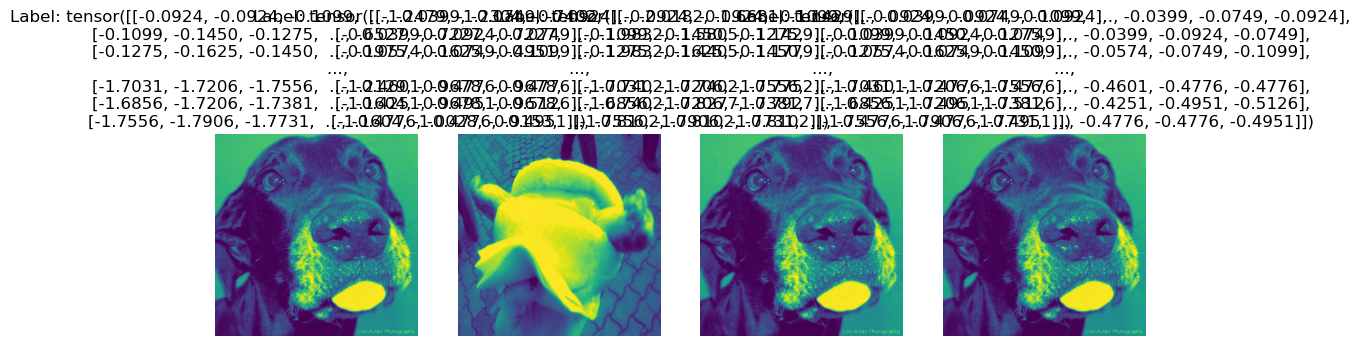

In [99]:
images, labels, name = next(iter(train_loader))
visualize_samples(images, labels)

In [86]:
def visualize_samples(dataset, indices, title=None, count=4):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off') 

In [87]:
images, labels, name = next(iter(train_loader))

In [101]:
def image_shower(images, labels, n=10):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        
        with torch.no_grad():
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            print(preds)

            ax = plt.subplot(2,2,1)
            ax.axis('off')
            ax.set_title(f'Predicted: {load_imagenet_classes()[int(preds[0])]}')
            imshow(img.cpu().data[0])
            plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())

            model.train(mode=was_training)
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("hotgot", "not_hot_dog")

In [122]:
predicted[0]

tensor(145)

In [120]:
load_imagenet_classes()[int(predicted[:])]

ValueError: only one element tensors can be converted to Python scalars

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Real Labels:  not_hot_dog not_hot_dog not_hot_dog not_hot_dog hotdog not_hot_dog not_hot_dog not_hot_dog not_hot_dog not_hot_dog
Predicted:  umbrella EntleBucher guacamole Persian_cat hotdog   pug Leonberg Boston_bull fur_coat wire-haired_fox_terrier


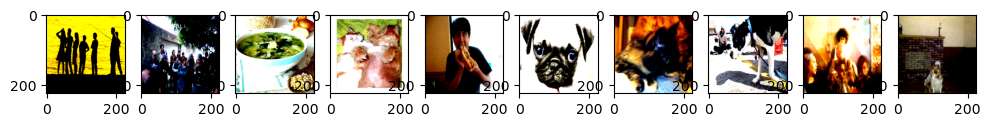

In [124]:
images, labels, _ = next(iter(train_loader))
image_shower(images, labels)

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %load_imagenet_classes()[int(predict)] for predict in predicted[:10] ))

In [ ]:
with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        print(preds)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {load_imagenet_classes()[int(preds[0])]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Labels:  hotdog hotdog hotdog hotdog


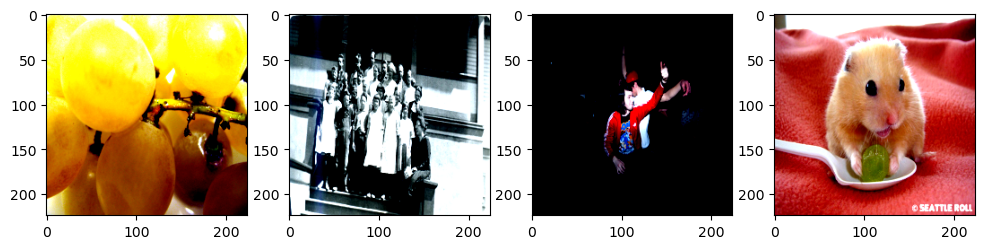

In [31]:
image_shower(images, labels)

In [ ]:
for sample in orig_dataset:
    print(sample)

In [16]:
count = 10
dataset = orig_dataset
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)

In [17]:
display_indices = indices[:count]
for i, index in enumerate(display_indices):
    print(f"i: {i}")
    print(f"index: {index}")
    x, y, _ = dataset[index]
    print(f"x: {x}")
    print(f"y: {y}")
    print(f"name: {_}")
    # plt.subplot(1,count,i+1)
    # plt.title("Label: %s" % y)
    # plt.imshow(x)
    # plt.grid(False)
    # plt.axis('off')

i: 0
index: 563
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x334 at 0x18F6C7179D0>
y: 0
name: food_5260.jpg
i: 1
index: 1479
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x338 at 0x18F6C7FAE10>
y: 1
name: frankfurter_6786.jpg
i: 2
index: 3549
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=192x144 at 0x18F6CB42950>
y: 0
name: pets_1039.jpg
i: 3
index: 2908
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x297 at 0x18F6C772F50>
y: 0
name: people_4166.jpg
i: 4
index: 3573
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x18F6C7733D0>
y: 0
name: pets_1073.jpg
i: 5
index: 3922
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=457x300 at 0x18F6C771F90>
y: 0
name: pets_1542.jpg
i: 6
index: 1933
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x373 at 0x18F6C77D910>
y: 0
name: furniture_3465.jpg
i: 7
index: 1585
x: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x18F6C77FD10>
y: 1

In [18]:
orig_dataset[3410]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 0,
 'people_4995.jpg')

In [19]:
count = 10
dataset = orig_dataset
indices = labels

display_indices = indices[:count]

In [20]:
count = 10
dataset = images
indices = labels

display_indices = indices[:count]

In [21]:
for i, index in enumerate(display_indices):
    #print(f"i: {i}")
    #print(f"index: {index}")
    x, y, _ = dataset[index]

    print(f"x: {x}")
    print(f"y: {y}")

x: tensor([[ 1.8722,  0.5193,  0.2624,  ..., -0.2513, -0.1657, -0.0458],
        [ 0.8961,  0.5193,  0.4166,  ..., -0.3712, -0.3541, -0.3369],
        [ 1.9578,  1.5468,  0.8618,  ..., -0.6281, -0.4739, -0.3883],
        ...,
        [ 0.1426,  0.5022,  0.3652,  ..., -1.5528, -1.5185, -1.5185],
        [ 1.4783,  1.4612,  0.6392,  ..., -1.3987, -1.5014, -1.5014],
        [ 0.7933,  0.5536,  0.9132,  ..., -1.4500, -1.4500, -1.3473]])
y: tensor([[ 2.0084,  0.6779,  0.4328,  ...,  0.8529,  0.8529,  0.9055],
        [ 0.9230,  0.3102,  0.3452,  ...,  0.4503,  0.6078,  0.6779],
        [ 2.0434,  1.7108,  1.0105,  ...,  0.2227,  0.4678,  0.5553],
        ...,
        [ 0.7654,  1.0980,  0.9055,  ..., -1.4230, -1.4580, -1.4055],
        [ 1.9734,  1.9559,  1.2381,  ..., -1.2654, -1.3354, -1.2829],
        [ 1.2556,  1.0630,  1.4832,  ..., -1.1954, -1.2654, -1.2129]])
x: tensor([[-0.8849, -0.6452, -0.7137,  ...,  0.4679,  0.4851,  0.4337],
        [-1.1247, -1.0904, -1.1760,  ...,  0.4508,  0

In [22]:
def visualize_samples_example(dataset, indices, title=None, count=4):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')                      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Labels:  not_hot_dog hotdog hotdog hotdog


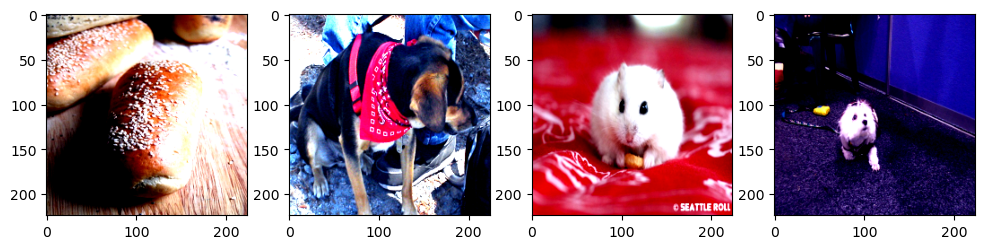

In [23]:
image_shower(images, labels);

In [ ]:
b = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # Use mean and std for pretrained models
        # https://pytorch.org/docs/stable/torchvision/models.html
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [ ]:
b(a)

In [ ]:
for sample in train_loader:
    print(sample)

In [ ]:
type(train_dataset)

In [ ]:
for sample in train_loader:
    print(sample)

In [ ]:
print(train_dataset)

Наши обычные функции для тренировки

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """

    model.eval() # Evaluation mode
    
    valid_loss_values = []
    valid_loss_acc = []
    
    running_loss = []
    running_acc = []

    with torch.no_grad():
        for i_step, (x, y, _) in enumerate(loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            acc_value = (prediction.argmax(dim=1)==y_gpu).sum()/len(y_gpu)
        
            running_loss.append(loss_value.item())
            running_acc.append(np.mean(acc_value))
    
    valid_loss_values.append(np.mean(running_loss))
    valid_loss_acc.append(np.mean(running_acc))
        
    
    
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    return valid_loss_values , valid_loss_acc


# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/vision/stable/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [33]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)
#model = model.to(device)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

In [44]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [45]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [61]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    #img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        print(preds)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {load_imagenet_classes()[int(preds[0])]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

tensor([933])


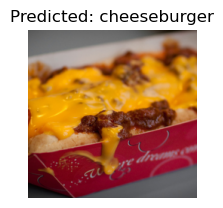

In [63]:
visualize_model_predictions(
    model,
    img_path="C:/Users/const31/Documents/OrNot/train_kaggle/chili-dog_7566.jpg")

plt.ioff()
plt.show()

In [38]:
len(train_loader)

58

In [39]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [40]:
train_loader

In [64]:
for sample in train_loader:
    img = sample["img"]
    label = sample['label']
    model(img)
    break

TypeError: list indices must be integers or slices, not str

In [66]:
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

parameters = None   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
parameters = None   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
loss = nn.CrossEntropyLoss()

optimizer = None # Hint - look into what PyTorch optimizers let you configure!
loss_history, train_history, val_history = train_model(model_conv, train_loader, val_loader, loss, optimizer, 5)

# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [ ]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    raise Exception("Not implemented")
    
    return predictions, ground_truth

predictions, gt = evaluate_model(model_conv, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

In [ ]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = None
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = None
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [ ]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше аугментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [ ]:
# TODO: Train your best model!
best_model = None

In [ ]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

# TODO: Visualize training curve for the best model

## Визуализируйте ошибки лучшей модели

# TODO Visualize false positives and false negatives of the best model on the validation set